In [1]:
import sys
import os
sys.path.insert(0, os.getcwd())

In [2]:
import re
import ase
import pickle

import numpy as np
import pandas as pd

from pathlib import Path
from copy import deepcopy
from ase.io import read, write
from ase.visualize import view
from ase.data import atomic_numbers
from ase.geometry import find_mic

from atoms_operators import fingerprint_adslab
from gaspymongo import make_initial_atoms_from_doc, make_atoms_from_doc
from matplotlib import pyplot as plt

from sklearn.kernel_ridge import KernelRidge
np.random.seed(2)

In [3]:
with open("data/vacancy_1024.pkl", 'rb') as fp:
    docs = pickle.load(fp)
all_atoms = [make_atoms_from_doc(n) for n in docs]

In [4]:
# view(all_atoms)

In [5]:

atom_ref_energies = {'Al': 5.798958058888855,
                     'Cr': 10.420886314999981,
                     'Ti': 9.174196767999948,
                     'V': 9.912874512727244}

df = pd.DataFrame(np.zeros((len(docs), 4)))
df.columns = ['vacancy_energy', 'ref_energy', 'true', 'pred']
df['vacancy_energy'] = [n['vacancy_energy'] for n in docs]
df['ref_energy'] = [atom_ref_energies[n['vacancy_element']] for n in docs]
df['true'] = df['vacancy_energy'] - df['ref_energy'] # standardize the data according to their vacancy element

In [6]:
from dscribe.descriptors import SOAP

species = [13, 22, 23, 24]
r_cut = 6.0
n_max = 7
l_max = 7

# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=True,
    r_cut=r_cut,
    n_max=n_max,
    l_max=l_max,
    average="inner",
)

In [7]:
# Generate SOAP descriptors for the top layer of atoms
X = []
for idx, data in df.iterrows():
    atoms = all_atoms[idx]
    X.append(soap.create(atoms, np.argsort(atoms.positions[:, -1])[-15:])) 

0.19014699882218986


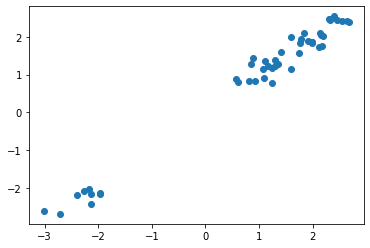

In [8]:
# ML cross validation
from sklearn.model_selection import KFold
X_all = np.array(X)
y = df['true'].values
kf = KFold(n_splits=5, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train = X_all[train_index]
    y_train = y[train_index]
    _X_test = X_all[test_index]
    _y_test = y[test_index]
    krr = KernelRidge(alpha=0.0001, gamma=1.1920928955078125e-07, kernel='rbf')
    krr.fit(X_train, y_train)
    y_pred = krr.predict(_X_test)
    df.loc[test_index, 'pred'] = y_pred
    
print((df['pred'] - df['true']).abs().mean())
df['true'] += df['ref_energy'] - 8.1046 # reverse standardize and add the universal correction
df['pred'] += df['ref_energy'] - 8.1046 
plt.scatter(df['true'], df['pred'])
plt.show()